In [24]:
# KERAS NEURAL NETWORKS
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.utils import multi_gpu_model, to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

# PROCESS DATA
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# PLOT DATA
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 16,12

import scipy as sp

import numpy as np

import sklearn
from sklearn import model_selection, feature_selection, metrics

# SCIKIT-LEARN LEARNING ALGORITHMS
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process, neural_network

# XGBOOST TREE
from xgboost import XGBClassifier

import re as re

import time

In [25]:
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')
train.head()

,PassengerId,Survived,Pclass,Sex,Group_survived,Has_group,FareBin_Code,AgeBin_Code,FamilySize
0,1,0,3,0,0.0,0,0,1,1
1,2,1,1,1,0.0,0,4,2,1
2,3,1,3,1,0.0,0,1,1,0
3,4,1,1,1,0.5,1,4,2,1
4,5,0,3,0,0.0,0,1,2,0


In [26]:
# split train and test data into two sets: group and no group

X_train_nogroup = train.loc[train['Has_group']==0].drop(['Has_group', 'Group_survived', 'Survived', 'PassengerId'], axis=1)
X_train_nogroup_id = train.loc[train['Has_group']==0]['PassengerId']
X_train_group = train.loc[train['Has_group']==1].drop(['Has_group', 'Survived', 'PassengerId'], axis=1)
X_train_group_id = train.loc[train['Has_group']==1]['PassengerId']

Y_train_nogroup = train.loc[train['Has_group']==0]['Survived']
Y_train_group = train.loc[train['Has_group']==1]['Survived']

print(X_train_nogroup.head())
print(X_train_group.head())
print(Y_train_nogroup.head())
print(Y_train_group.head())
print('-' * 20)

X_test_nogroup = test.loc[(test['Has_group']==0) | ((test['Group_survived']==-1) & (test['Sex']==1))].drop(['Has_group', 'Group_survived', 'PassengerId'], axis=1)
X_test_nogroup_id = test.loc[(test['Has_group']==0) | ((test['Group_survived']==-1) & (test['Sex']==1))]['PassengerId']
X_test_group = test.loc[(test['Has_group']==1) & ((test['Group_survived']>-1) | (test['Sex']==0))].drop(['Has_group', 'PassengerId'], axis=1)
X_test_group_id = test.loc[(test['Has_group']==1) & ((test['Group_survived']>-1) | (test['Sex']==0))]['PassengerId']

print(X_test_nogroup.head())
print(X_test_group.head())

   Pclass  Sex  FareBin_Code  AgeBin_Code  FamilySize
0       3    0             0            1           1
1       1    1             4            2           1
2       3    1             1            1           0
4       3    0             1            2           0
5       3    0             1            0           0
    Pclass  Sex  Group_survived  FareBin_Code  AgeBin_Code  FamilySize
3        1    1             0.5             4            2           1
7        3    0             0.0             2            0           4
8        3    1             1.0             2            1           2
9        2    1             0.5             3            0           1
10       3    1             1.0             2            0           2
0    0
1    1
2    1
4    0
5    0
Name: Survived, dtype: int64
3     1
7     0
8     1
9     1
10    1
Name: Survived, dtype: int64
--------------------
   Pclass  Sex  FareBin_Code  AgeBin_Code  FamilySize
0       3    0             0            2 

In [27]:
# Experiment with architectures
Models = [
    #ensemble
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    #gaussian process
    gaussian_process.GaussianProcessClassifier(),
    
    #linear model
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #naive bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #neighbours,
    neighbors.KNeighborsClassifier(),
    neighbors.NearestCentroid(),
    
    #svm
    svm.LinearSVC(),
    svm.NuSVC(),
    svm.SVC(),
    
    #decision tree
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #discriminant analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    #xgboost
    XGBClassifier()
]

In [28]:
# proceed to fit and predict no group data first

# split data for cross validation purposes
cv_split = model_selection.StratifiedShuffleSplit(n_splits=20, test_size = 0.3, train_size = 0.6, random_state=0)
#when cross validating, using this cv_split, the algorithm will run 10 times (n_splits)

# create table to compare machine learning algorithm performance
Model_columns_nogroup = ['Model Name', 'Model Parameters','Model Train Accuracy Mean', 'Model Test Accuracy Mean', 'Model Test Accuracy 3*STD' ,'Model Time']
Model_compare_nogroup = pd.DataFrame(columns = Model_columns_nogroup)
Model_predict_nogroup = train.loc[train['Has_group']==0].drop(['Pclass', 'Sex', 'FamilySize', 'PassengerId', 'Group_survived', 'Has_group', 'FareBin_Code', 'AgeBin_Code'], axis=1).copy(deep=True) # need to save each model predictions for later

row = 0
for alg in Models:
    
    Model_name = alg.__class__.__name__
    Model_compare_nogroup.loc[row, 'Model Name'] = Model_name
    Model_compare_nogroup.loc[row, 'Model Parameters'] = str(alg.get_params())
    
    # score models with cross validation
    cv_results = model_selection.cross_validate(alg, X=X_train_nogroup, y=Y_train_nogroup, cv = cv_split, n_jobs=-1, return_train_score=True)
    
    #print(cv_results)
    
    Model_compare_nogroup.loc[row, 'Model Time'] = cv_results['fit_time'].mean()
    Model_compare_nogroup.loc[row, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
    Model_compare_nogroup.loc[row, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # if this is a non-bias random sample, then +/-3 standard deviations from the mean should statistically capture 99.7% of the subsets
    Model_compare_nogroup.loc[row, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # figure out the worst possible score
    
    #save Model predictions for later use in ensembling all high-performing models
    alg.fit(X_train_nogroup, Y_train_nogroup)
    Model_predict_nogroup[Model_name] = alg.predict(X_train_nogroup)
    
    row = row + 1
    
# print and sort table
Model_compare_nogroup.sort_values(by = ['Model Test Accuracy Mean'], ascending=False, inplace=True)
Model_compare_nogroup

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in

,Model Name,Model Parameters,Model Train Accuracy Mean,Model Test Accuracy Mean,Model Test Accuracy 3*STD,Model Time
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.820884,0.826667,0.0719044,0.00233724
15,LinearSVC,"{'C': 1.0, 'class_weight': None, 'dual': True,...",0.820884,0.826364,0.0718757,0.00956888
20,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.820732,0.825152,0.0697753,0.00166982
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.819817,0.823333,0.0688212,0.00134516
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.821037,0.82303,0.0712579,0.0859542
16,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.827591,0.816667,0.064507,0.00334903
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.865244,0.815455,0.0646606,0.00682656
17,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.828659,0.815152,0.0693536,0.00290614
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.856555,0.814848,0.0726079,0.0485253
22,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.846951,0.812727,0.061092,3.13396


Text(0, 0.5, 'Algorithm')

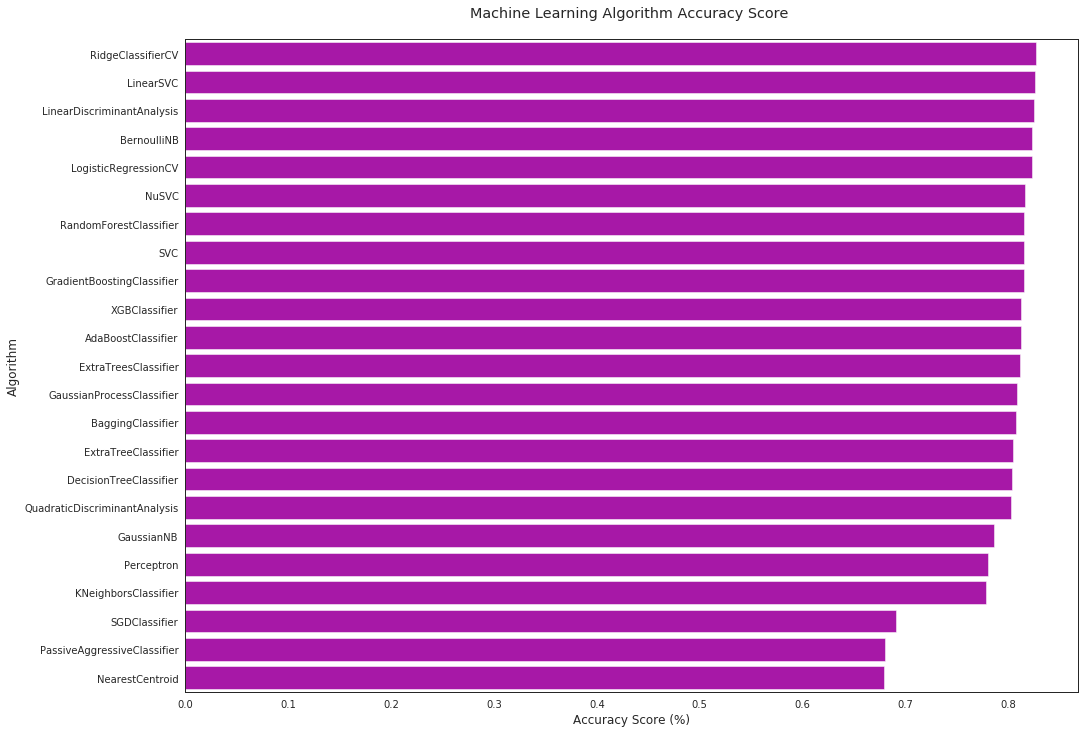

In [29]:
# barplot
sns.barplot(x='Model Test Accuracy Mean', y = 'Model Name', data = Model_compare_nogroup, color = 'm')

# prettify with pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

In [30]:
# perform feature selection
# use decision tree to tune feature selection

ridge = linear_model.RidgeClassifierCV()
ridge_rfe = feature_selection.RFECV(ridge, step=1, scoring = 'accuracy', cv = cv_split)
X_rfe_nogroup = ridge_rfe.fit_transform(X_train_nogroup, Y_train_nogroup)

#X_rfe_nogroup = X_train_nogroup[:, ridge_rfe.get_support()]
rfe_results = model_selection.cross_validate(ridge, X_rfe_nogroup, Y_train_nogroup, cv = cv_split, return_train_score=True)

base_results = model_selection.cross_validate(ridge, X_train_nogroup, Y_train_nogroup, cv = cv_split, return_train_score=True)

print('BEFORE DT RFE Training Old Shape: ', X_train_nogroup.shape)
print('BEFORE DT RFE Training Old Columns: ', X_train_nogroup.columns.values)

print('BEFORE DT RFE Training w/bin score mean: {:.2f}'.format(base_results['train_score'].mean()*100))
print('BEFORE DT RFE Test w/bin score mean: {:.2f}'.format(base_results['test_score'].mean()*100))
print('BEFORE DT RFE Test w/bin score 3*std: {:.2f}'.format(base_results['test_score'].std()*3*100))
print('-'*10)

print('AFTER DT RFE Training New Shape: ', X_rfe_nogroup.shape)
print('AFTER DT RFE Training New Columns: ', train.drop(['Has_group', 'Group_survived', 'Survived', 'PassengerId'], axis=1).columns.values[ridge_rfe.get_support()])

print('AFTER DT RFE Training w/bin score mean: {:.2f}'.format(rfe_results['train_score'].mean()*100))
print('AFTER DT RFE Test w/bin score mean: {:.2f}'.format(rfe_results['test_score'].mean()*100))
print('AFTER DT RFE Test w/bin score 3*std: {:.2f}'.format(rfe_results['test_score'].std()*3*100))
print('-'*10)

param_grid = {'alphas': [[0.01, 0.03, 0.1, 0.3, 1, 3, 10]],
             'fit_intercept': [True, False],
             'normalize': [True, False]}

tune_model = model_selection.GridSearchCV(linear_model.RidgeClassifierCV(), param_grid=param_grid, scoring='roc_auc', cv=cv_split, n_jobs = -1, return_train_score=True)
tune_model.fit(X_rfe_nogroup, Y_train_nogroup)

print('AFTER DT RFE Tuned Parameters: ', tune_model.best_params_)

print('AFTER DT RFE Training w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100))
print('AFTER DT RFE Test w/bin score mean: {:.2f}'.format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print('AFTER DT RFE Test w/bin score 3*std: {:.2f}'.format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*3*100))
print('-'*10)

BEFORE DT RFE Training Old Shape:  (547, 5)
BEFORE DT RFE Training Old Columns:  ['Pclass' 'Sex' 'FareBin_Code' 'AgeBin_Code' 'FamilySize']
BEFORE DT RFE Training w/bin score mean: 82.09
BEFORE DT RFE Test w/bin score mean: 82.67
BEFORE DT RFE Test w/bin score 3*std: 7.19
----------
AFTER DT RFE Training New Shape:  (547, 1)
AFTER DT RFE Training New Columns:  ['Sex']
AFTER DT RFE Training w/bin score mean: 82.09
AFTER DT RFE Test w/bin score mean: 82.73
AFTER DT RFE Test w/bin score 3*std: 7.26
----------
AFTER DT RFE Tuned Parameters:  {'alphas': [0.01, 0.03, 0.1, 0.3, 1, 3, 10], 'fit_intercept': True, 'normalize': True}
AFTER DT RFE Training w/bin score mean: 76.15
AFTER DT RFE Test w/bin score mean: 76.75
AFTER DT RFE Test w/bin score 3*std: 10.25
----------


In [31]:
# create table to compare machine learning algorithm performance
Model_columns_nogroup_rfe = ['Model Name', 'Model Parameters','Model Train Accuracy Mean', 'Model Test Accuracy Mean', 'Model Test Accuracy 3*STD' ,'Model Time']
Model_compare_nogroup_rfe = pd.DataFrame(columns = Model_columns_nogroup_rfe)
Model_predict_nogroup_rfe = train.loc[train['Has_group']==0].drop(['Pclass', 'Sex', 'FamilySize', 'PassengerId', 'Group_survived', 'Has_group', 'FareBin_Code', 'AgeBin_Code'], axis=1).copy(deep=True) # need to save each model predictions for later

row = 0
for alg in Models:
    
    Model_name = alg.__class__.__name__
    Model_compare_nogroup_rfe.loc[row, 'Model Name'] = Model_name
    Model_compare_nogroup_rfe.loc[row, 'Model Parameters'] = str(alg.get_params())
    
    # score models with cross validation
    cv_results = model_selection.cross_validate(alg, X=X_rfe_nogroup, y=Y_train_nogroup, cv = cv_split, n_jobs=-1, return_train_score=True)
    
    #print(cv_results)
    
    Model_compare_nogroup_rfe.loc[row, 'Model Time'] = cv_results['fit_time'].mean()
    Model_compare_nogroup_rfe.loc[row, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
    Model_compare_nogroup_rfe.loc[row, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # if this is a non-bias random sample, then +/-3 standard deviations from the mean should statistically capture 99.7% of the subsets
    Model_compare_nogroup_rfe.loc[row, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # figure out the worst possible score
    
    #save Model predictions for later use in ensembling all high-performing models
    alg.fit(X_rfe_nogroup, Y_train_nogroup)
    Model_predict_nogroup_rfe[Model_name] = alg.predict(X_rfe_nogroup)
    
    row = row + 1
    
# print and sort table
Model_compare_nogroup_rfe.sort_values(by = ['Model Time'], ascending=True, inplace=True)
Model_compare_nogroup_rfe

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in PassiveAggressiveClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None.

,Model Name,Model Parameters,Model Train Accuracy Mean,Model Test Accuracy Mean,Model Test Accuracy 3*STD,Model Time
19,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.820884,0.827273,0.0726135,0.000373018
14,NearestCentroid,"{'metric': 'euclidean', 'shrink_threshold': None}",0.820884,0.827273,0.0726135,0.000396895
18,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.820884,0.827273,0.0726135,0.000429058
21,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.820884,0.827273,0.0726135,0.000439215
12,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.820884,0.827273,0.0726135,0.000540197
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.815244,0.819091,0.10449,0.000657225
9,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.681098,0.682121,0.601169,0.000727797
20,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.820884,0.827273,0.0726135,0.00074774
11,BernoulliNB,"{'alpha': 1.0, 'binarize': 0.0, 'class_prior':...",0.820884,0.827273,0.0726135,0.000756097
10,Perceptron,"{'alpha': 0.0001, 'class_weight': None, 'early...",0.766463,0.77,0.191253,0.000847864


Text(0, 0.5, 'Algorithm')

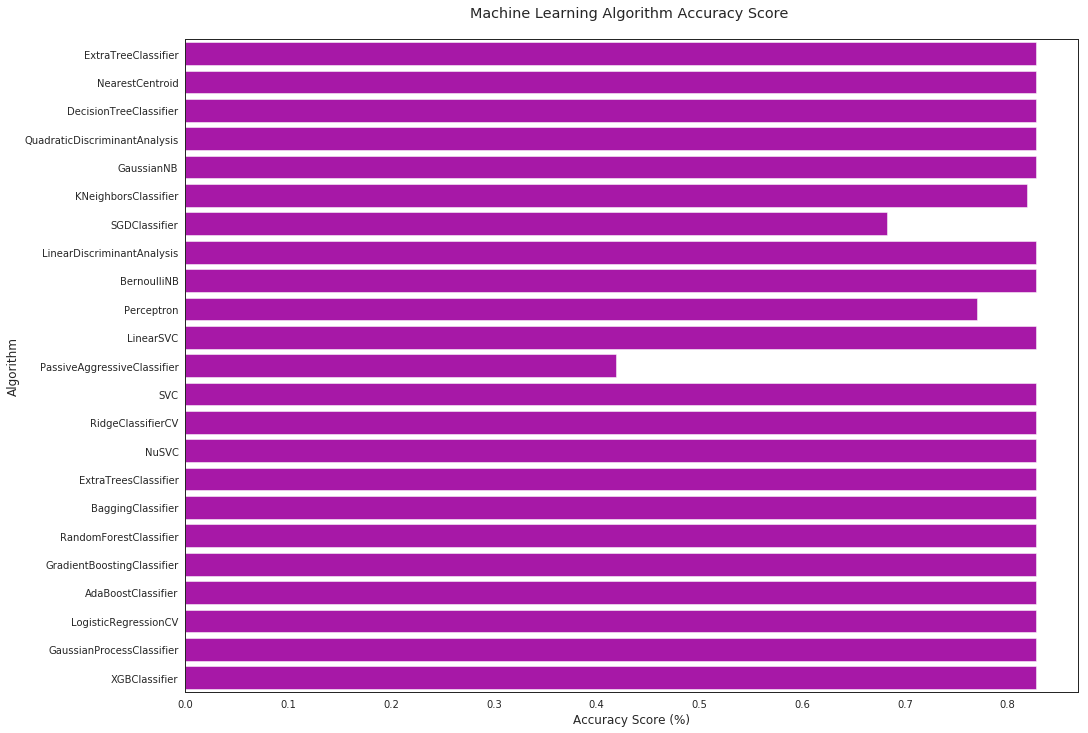

In [32]:
# barplot
sns.barplot(x='Model Test Accuracy Mean', y = 'Model Name', data = Model_compare_nogroup_rfe, color = 'm')

# prettify with pyplot
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

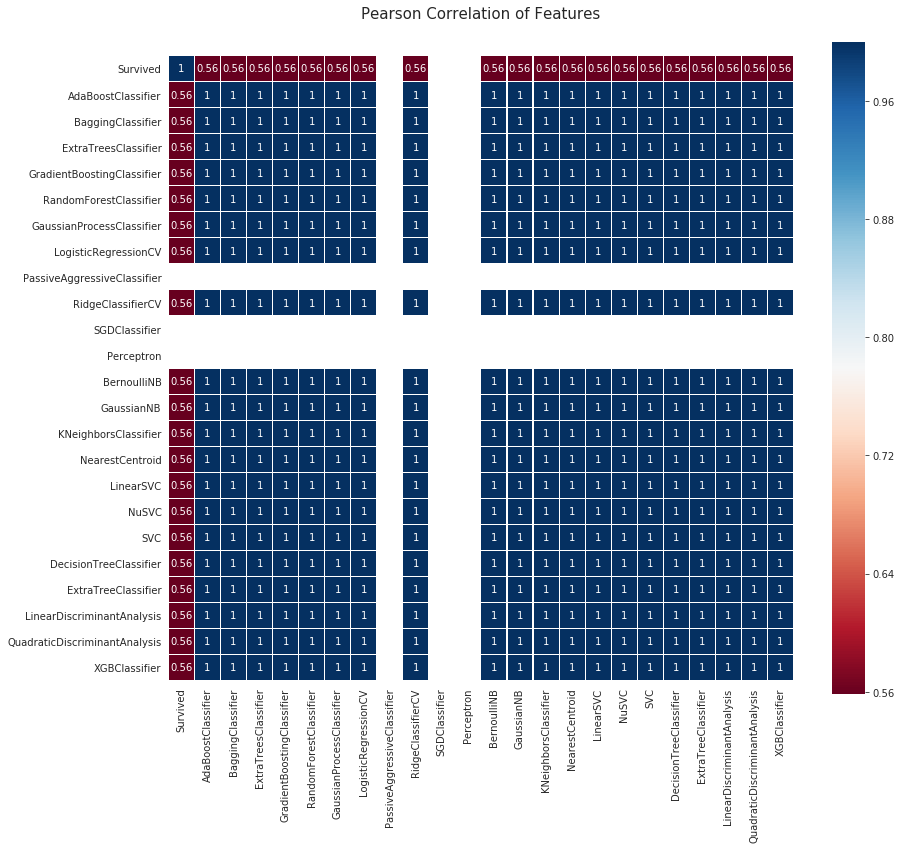

In [33]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(Model_predict_nogroup_rfe.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [18]:
# predict no group test set

X_test_rfe_nogroup = X_test_nogroup[X_test_nogroup.columns.values[ridge_rfe.get_support()]]
dtree = tree.DecisionTreeClassifier()
dtree.fit(X_rfe_nogroup, Y_train_nogroup)
Y_test_nogroup = dtree.predict(X_test_rfe_nogroup)#.reshape((-1,1))
print(Y_test_nogroup[:10])

[0 1 0 0 1 0 1 1 0 0]


In [44]:
Survived_nogroup = pd.Series(Y_test_nogroup, name='Survived')
test_nogroup = pd.concat([X_test_nogroup_id.reset_index(), Survived_nogroup], axis=1).drop('index', axis=1)
#test_nogroup = test_nogroup.astype(int)
test_nogroup.head(30)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,900,1
8,902,0
9,903,0


In [11]:
# BUILD SUPER PREDICTOR

vote_predict = [
    #ensemble
    ('ada', ensemble.AdaBoostClassifier()),
    ('bag', ensemble.BaggingClassifier()),
    ('etc', ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),
    
    #gaussian process
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #linear model
    ('lr', linear_model.LogisticRegressionCV()),
    
    #naive bayes
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #neighbours,
    ('knn', neighbors.KNeighborsClassifier()),
    
    #svm
    ('svc', svm.SVC(probability=True)),
    
    #xgboost
    ('xgb', XGBClassifier())
]

# hard vote/majority rules
hard_vote = ensemble.VotingClassifier(estimators = vote_predict, voting = 'hard')
hard_vote_cv = model_selection.cross_validate(hard_vote, X_rfe, Y_train, cv=cv_split, n_jobs=-1)
hard_vote.fit(X_rfe, Y_train)

print("Hard Voting Training w/bin score mean: {:.2f}". format(hard_vote_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(hard_vote_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(hard_vote_cv['test_score'].std()*100*3))
print('-'*10)

# soft vote or weighted probabilities
soft_vote = ensemble.VotingClassifier(estimators = vote_predict, voting = 'hard')
soft_vote_cv = model_selection.cross_validate(soft_vote, X_rfe, Y_train, cv=cv_split, n_jobs=-1)
soft_vote.fit(X_rfe, Y_train)

print("Soft Voting Training w/bin score mean: {:.2f}". format(soft_vote_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(soft_vote_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(soft_vote_cv['test_score'].std()*100*3))
print('-'*10)

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in versi

Hard Voting Training w/bin score mean: 83.89
Hard Voting Test w/bin score mean: 82.39
Hard Voting Test w/bin score 3*std: +/- 5.95
----------


/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Soft Voting Training w/bin score mean: 83.91
Soft Voting Test w/bin score mean: 82.18
Soft Voting Test w/bin score 3*std: +/- 6.59
----------


/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [12]:
n_estimators = [10, 30, 50, 100, 300]
learning_rate = [0.0001, 0.0003, 0.001, 0.003, 0.1, 0.3, 1]
max_depth = [2, 4, 6, 8, 10, None]
random_state = [0, 1, 2, 4, 8]
ratio = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
criterion = ['gini', 'entropy']
min_samples_split = [2, 4, 8, 16]
min_samples_leaf = [1, 2, 4]
min_weight_fraction_leaf = [0, 0.001, 0.01, 0.1, 0.2, 0.4]
max_features = [None]

grid_param = [[{
    #ADABOOST
    'n_estimators': [100],
    'learning_rate': [0.0001],
    'algorithm': ['SAMME.R'],
    'random_state': [0]
}],
[{
    #BAGGING
    'n_estimators': [50],
    'max_samples': [0.8],
    'max_features': [3],
    'bootstrap': [False],
    'bootstrap_features': [False],
    'n_jobs': [-1],
    'random_state': [8]
}],
[{
    #EXTRATREES
    'n_estimators': [100],
    'criterion': ['gini'],
    'max_depth': [4],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'max_features': [None],
    'n_jobs': [-1],
    'random_state': [0],
}],
[{
    #GRADIENTBOOSTING
    'loss': ['deviance'],
    'learning_rate': [0.003],
    'n_estimators': [300],
    'criterion': ['mse'],
    'min_samples_split': [16],
    'min_samples_leaf': [1],
    'max_depth': [4],
    'random_state': [1],
    'max_features': [None]
}],
[{
    #RANDOMFOREST
    'n_estimators': [50],
    'criterion': ['entropy'],
    'max_depth': [4],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': [None],
    'n_jobs': [-1],
    'random_state': [0]
}],
[{
    #GAUSSIANPROCESS
    'max_iter_predict': [10],
    'random_state': [0],
    'n_jobs': [-1]
}],
[{
    #LOGISTICREGRESSION
    'fit_intercept': [True],
    'solver': ['sag'],
    'max_iter': [10],
    'class_weight': [None],
    'n_jobs': [-1],
    'random_state': [0]
}],
[{
    #BERNOULLINAIVEBAYES
    'alpha': [0.1]
}],
[{
    #GAUSSIANNAIVEBAYES
}],
[{
    #KNEIGHBOURS
    'n_neighbors': [8],
    'weights': ['uniform'],
    'algorithm': ['ball_tree'],
    'leaf_size': [10],
    'n_jobs': [-1]
}],
[{
    #SVC
    'C': [1],
    'kernel': ['linear'],
    'gamma': ['auto'],
    'probability' : [True],
    'class_weight': ['balanced'],
    'decision_function_shape': ['ovo'],
    'random_state': [0]
}],
[{
    #XGB
    'max_depth': [4],
    'learning_rate': [0.0001],
    'n_estimators': [10],
    'n_jobs': [-1],
    'reg_lambda': [0.03],
    'random_state': [0],
    'tree_method': ['gpu_exact']
}]]

start_total = time.perf_counter()

for clf, param in zip (vote_predict, grid_param):
    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator=clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc', n_jobs=-1, return_train_score=True)
    best_search.fit(X_rfe, Y_train)
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param)
    
run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for AdaBoostClassifier is {'algorithm': 'SAMME.R', 'learning_rate': 0.0001, 'n_estimators': 100, 'random_state': 0} with a runtime of 0.34 seconds.
The best parameter for BaggingClassifier is {'bootstrap': False, 'bootstrap_features': False, 'max_features': 3, 'max_samples': 0.8, 'n_estimators': 50, 'n_jobs': -1, 'random_state': 8} with a runtime of 0.76 seconds.
The best parameter for ExtraTreesClassifier is {'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'n_jobs': -1, 'random_state': 0} with a runtime of 1.05 seconds.
The best parameter for GradientBoostingClassifier is {'criterion': 'mse', 'learning_rate': 0.003, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'n_estimators': 300, 'random_state': 1} with a runtime of 0.66 seconds.
The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 4, 'max_feat

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


The best parameter for LogisticRegressionCV is {'class_weight': None, 'fit_intercept': True, 'max_iter': 10, 'n_jobs': -1, 'random_state': 0, 'solver': 'sag'} with a runtime of 0.73 seconds.
The best parameter for BernoulliNB is {'alpha': 0.1} with a runtime of 0.03 seconds.
The best parameter for GaussianNB is {} with a runtime of 0.03 seconds.
The best parameter for KNeighborsClassifier is {'algorithm': 'ball_tree', 'leaf_size': 10, 'n_jobs': -1, 'n_neighbors': 8, 'weights': 'uniform'} with a runtime of 0.46 seconds.
The best parameter for SVC is {'C': 1, 'class_weight': 'balanced', 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear', 'probability': True, 'random_state': 0} with a runtime of 0.13 seconds.
The best parameter for XGBClassifier is {'learning_rate': 0.0001, 'max_depth': 4, 'n_estimators': 10, 'n_jobs': -1, 'random_state': 0, 'reg_lambda': 0.03, 'tree_method': 'gpu_exact'} with a runtime of 0.27 seconds.
Total optimization time was 0.66 minutes.
--------

In [13]:
for clf in vote_predict:
    print(clf[1].get_params())
    print('\n')

{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.0001, 'n_estimators': 100, 'random_state': 0}


{'base_estimator': None, 'bootstrap': False, 'bootstrap_features': False, 'max_features': 3, 'max_samples': 0.8, 'n_estimators': 50, 'n_jobs': -1, 'oob_score': False, 'random_state': 8, 'verbose': 0, 'warm_start': False}


{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


{'criterion': 'mse', 'init': None, 'learning_rate': 0.003, 'loss': 'deviance', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 16, 'min_weight_fraction_leaf': 0.0, 'n_est

In [14]:
hard_vote_grid = ensemble.VotingClassifier(estimators=vote_predict, voting='hard')
hard_vote_grid_cv = model_selection.cross_validate(hard_vote_grid, X_rfe, Y_train, cv=cv_split)
hard_vote_grid.fit(X_rfe, Y_train)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(hard_vote_grid_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(hard_vote_grid_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(hard_vote_grid_cv['test_score'].std()*100*3))
print('-'*10)

soft_vote_grid = ensemble.VotingClassifier(estimators=vote_predict, voting='soft')
soft_vote_grid_cv = model_selection.cross_validate(soft_vote_grid, X_rfe, Y_train, cv=cv_split)
soft_vote_grid.fit(X_rfe, Y_train)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(soft_vote_grid_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(soft_vote_grid_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(soft_vote_grid_cv['test_score'].std()*100*3))
print('-'*10)

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 83.63
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.74
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.62
----------


/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 83.66
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.72
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.71
----------


/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [16]:
PassengerId = pd.Series([i for i in range(892, 1310)], name='PassengerId')

print(test.columns.values)
X_test = test.to_numpy().reshape((-1,9))
X_test_rfe = X_test[:, dtree_rfe.get_support()]

results = pd.Series([0 for i in range(892,1310)], name='Survived')

submission = pd.concat([PassengerId, results], axis=1)

print(submission.info())

submission['Survived'] = hard_vote_grid.predict(X_test_rfe)

submission.head()

submission.to_csv('SUBMISSION-ENSEMBLE-VOTE.csv', index=False)

['Pclass' 'Sex' 'Age' 'Fare' 'Embarked' 'Title' 'IsNotAlone' 'FamilySize'
 'HasCabin']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
PassengerId    418 non-null int64
Survived       418 non-null int64
dtypes: int64(2)
memory usage: 6.6 KB
None


In [22]:
# create table to compare machine learning algorithm performance
Model_columns = ['Model Name', 'Model Parameters','Model Train Accuracy Mean', 'Model Test Accuracy Mean', 'Model Test Accuracy 3*STD' ,'Model Time']
Model_compare = pd.DataFrame(columns = Model_columns)
Model_predict = train.drop(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'IsNotAlone', 'FamilySize', 'HasCabin'], axis=1).copy(deep=True) # need to save each model predictions for later

row = 0
for alg in vote_predict:
    
    Model_name = alg[1].__class__.__name__
    Model_compare.loc[row, 'Model Name'] = Model_name
    Model_compare.loc[row, 'Model Parameters'] = str(alg[1].get_params())
    
    # score models with cross validation
    cv_results = model_selection.cross_validate(alg[1], X=X_train, y=Y_train, cv = cv_split, n_jobs=-1, return_train_score=True)
    
    #print(cv_results)
    
    Model_compare.loc[row, 'Model Time'] = cv_results['fit_time'].mean()
    Model_compare.loc[row, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
    Model_compare.loc[row, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()
    
    # if this is a non-bias random sample, then +/-3 standard deviations from the mean should statistically capture 99.7% of the subsets
    Model_compare.loc[row, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # figure out the worst possible score
    
    #save Model predictions for later use in ensembling all high-performing models
    alg[1].fit(X_train, Y_train)
    Model_predict[Model_name] = alg[1].predict(X_train)
    
    row = row + 1
    
# print and sort table
Model_compare.sort_values(by = ['Model Test Accuracy Mean'], ascending=False, inplace=True)
Model_compare

/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/jason/anaconda3/envs/tensorflow_env/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge",

,Model Name,Model Parameters,Model Train Accuracy Mean,Model Test Accuracy Mean,Model Test Accuracy 3*STD,Model Time
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': False, '...",0.860206,0.825,0.0495454,0.104383
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.885019,0.821642,0.0488706,1.38317
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.854213,0.821269,0.053204,0.131684
3,GradientBoostingClassifier,"{'criterion': 'mse', 'init': None, 'learning_r...",0.852528,0.821269,0.0522535,0.274814
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.844288,0.81903,0.0561378,0.155295
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.828184,0.816978,0.05037,0.155301
11,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.84691,0.811567,0.0546677,0.145026
9,KNeighborsClassifier,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",0.849064,0.80653,0.0591565,0.000982249
10,SVC,"{'C': 1, 'cache_size': 200, 'class_weight': 'b...",0.808708,0.797015,0.0589576,0.0287207
7,BernoulliNB,"{'alpha': 0.1, 'binarize': 0.0, 'class_prior':...",0.792603,0.794216,0.0590505,0.000661039


In [23]:
Model_name = dtree.__class__.__name__
Model_compare.loc[row, 'Model Name'] = Model_name
Model_compare.loc[row, 'Model Parameters'] = str(dtree.get_params())

# score models with cross validation
cv_results = model_selection.cross_validate(dtree, X=X_train, y=Y_train, cv = cv_split, n_jobs=-1, return_train_score=True)

#print(cv_results)

Model_compare.loc[row, 'Model Time'] = cv_results['fit_time'].mean()
Model_compare.loc[row, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean()
Model_compare.loc[row, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()

# if this is a non-bias random sample, then +/-3 standard deviations from the mean should statistically capture 99.7% of the subsets
Model_compare.loc[row, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3 # figure out the worst possible score

#save Model predictions for later use in ensembling all high-performing models
dtree.fit(X_train, Y_train)
Model_predict[Model_name] = dtree.predict(X_train)

row = row + 1

Model_compare.sort_values(by = ['Model Test Accuracy Mean'], ascending=False, inplace=True)
Model_compare

,Model Name,Model Parameters,Model Train Accuracy Mean,Model Test Accuracy Mean,Model Test Accuracy 3*STD,Model Time
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': False, '...",0.860206,0.825,0.0495454,0.104383
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.885019,0.821642,0.0488706,1.38317
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.854213,0.821269,0.053204,0.131684
3,GradientBoostingClassifier,"{'criterion': 'mse', 'init': None, 'learning_r...",0.852528,0.821269,0.0522535,0.274814
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.844288,0.81903,0.0561378,0.155295
12,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'entropy',...",0.842322,0.818097,0.0492887,0.000504303
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.828184,0.816978,0.05037,0.155301
11,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.84691,0.811567,0.0546677,0.145026
9,KNeighborsClassifier,"{'algorithm': 'ball_tree', 'leaf_size': 10, 'm...",0.849064,0.80653,0.0591565,0.000982249
10,SVC,"{'C': 1, 'cache_size': 200, 'class_weight': 'b...",0.808708,0.797015,0.0589576,0.0287207
